In [1]:
# !pip install torch-geometric

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import KarateClub
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv
from torch_geometric.utils import to_networkx
from torch_geometric.utils import to_dense_adj
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import networkx as nx
from sklearn.metrics import confusion_matrix
import import_ipynb
from util import utils

# 加载图数据

## KarateClub数据集

In [3]:
# dataset = KarateClub()

## Cora数据集

In [4]:
dataset = Planetoid(root='./dataset', name='Cora')

In [5]:
dataset[0].x.size()

torch.Size([2708, 1433])

In [6]:
dataset[0].num_nodes, dataset[0].num_edges, dataset.num_features, dataset.num_classes

(2708, 10556, 1433, 7)

In [7]:
# 获取训练集、验证集和测试集数据量
print('训练集节点数量:', sum(dataset[0].train_mask).numpy().item())
# print('验证集节点数量:', sum(dataset[0].val_mask).numpy().item())
# print('测试集节点数量:', sum(dataset[0].test_mask).numpy().item())

训练集节点数量: 140


In [8]:
# 检查数据集是否是无向图
print(dataset[0].is_undirected())

True


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [10]:
data = dataset[0].to(device)

In [11]:
# 一次加载多少幅图
batch_size = 1
# 创建数据加载器
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
data.edge_index.size()

torch.Size([2, 10556])

In [13]:
# edge_index转换为邻接矩阵
adjacency_matrix = utils.edge_index_2_adjacency_matrix(data.edge_index)
adjacency_matrix.size()

torch.Size([2708, 2708])

## 图数据可视化

In [14]:
# 图可视化函数
def visualize_graph(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])
    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=30, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False, node_size=30, node_color=color, cmap="Set2")
    plt.show()

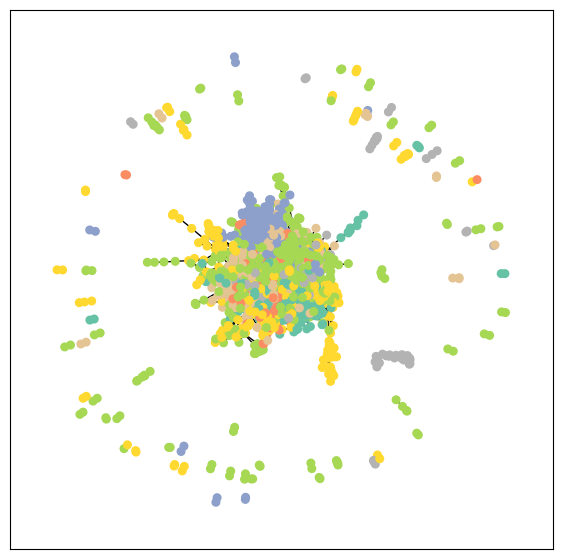

In [15]:
G = to_networkx(data.to('cpu'), to_undirected=True)
visualize_graph(G, color=data.y)

# 定义图神经网络模型

## MyGCNConv

In [16]:
class MyGCNConv(nn.Module):
    def __init__(self, in_features, out_features):
        super(MyGCNConv, self).__init__()
        # GCN层中待训练的weight和bias矩阵
        self.weight = torch.nn.Parameter(nn.init.xavier_normal_(torch.zeros(in_features, out_features)))
        self.bias = torch.nn.Parameter(torch.zeros([out_features]))
  
    def forward(self, x, edge_index):
        # 邻接矩阵
        adj = utils.edge_index_2_adjacency_matrix(edge_index)
        # 邻接矩阵 + I，即每个节点添加指向自己的边，将节点自身信息汇聚进去
        adj += torch.eye(x.shape[0]).to(adj)
        # 度（出或入）矩阵，即Degree matrix
        dgr = torch.diag(adj.sum(1) ** -0.5)
        # 对称归一化邻接矩阵，即Normalized adjacency matrix，
        adj_hat = dgr @ adj @ dgr
        # 特征矩阵的线性变换，即Graph Convolution operation
        y = adj_hat @ x @ self.weight + self.bias
        return y

In [17]:
# Example usage
# Feature matrix with 4 nodes and 3 features each
X = torch.rand(4, 3)  
# Adjacency matrix
A = torch.tensor([[1, 1, 0, 0], 
                  [1, 1, 1, 0], 
                  [0, 1, 1, 1], 
                  [0, 0, 1, 1]]
                ) 
edge_index = utils.adjacency_matrix_2_edge_index(A)
my_gcn_layer = MyGCNConv(3, 2)
output = my_gcn_layer(X, edge_index)
print(output)

tensor([[ 0.7523, -1.0494],
        [ 0.6861, -1.0014],
        [ 0.5154, -0.9007],
        [ 0.4508, -0.8537]], grad_fn=<AddBackward0>)


## GCN

In [18]:
class GCN(nn.Module): 

    def __init__(self, in_features, hidden_features, out_features): 
        super(GCN, self).__init__()
        torch.manual_seed(1234567)
        self.conv1 = MyGCNConv(in_features, hidden_features)
        self.conv2 = MyGCNConv(hidden_features, out_features)
    
    def forward(self, data):
        in_features, edge_index = data.x, data.edge_index
        out_features = self.conv1(in_features, edge_index)
        out_features = F.relu(out_features)
        # 对输入的节点特征进行Dropout操作，以减少过拟合风险。
        # p=0.5表示丢弃概率为0.5，即有50%的概率将输入置零。
        # out_features = F.dropout(out_features, p=0.5, training=self.training) 
        out_features = self.conv2(out_features, edge_index)
        # 预测类别
        out_features = F.softmax(out_features, dim=1)
        # out_features = F.log_softmax(out_features, dim=1)
        return out_features

## GraphSAGE

In [19]:
class GraphSAGE(nn.Module): 

    def __init__(self, in_features, hidden_features, out_features): 
        super(GraphSAGE, self).__init__()
        torch.manual_seed(1234567)
        self.conv1 = SAGEConv(in_features, hidden_features)
        self.conv2 = SAGEConv(hidden_features, out_features)
    
    def forward(self, data):
        in_features, edge_index = data.x, data.edge_index
        out_features = self.conv1(in_features, edge_index)
        out_features = F.relu(out_features)
        # 对输入的节点特征进行Dropout操作，以减少过拟合风险。
        # p=0.5表示丢弃概率为0.5，即有50%的概率将输入置零。
        # out_features = F.dropout(out_features, p=0.5, training=self.training) 
        out_features = self.conv2(out_features, edge_index)
        # 预测类别
        out_features = F.softmax(out_features, dim=1)
        # out_features = F.log_softmax(out_features, dim=1)
        return out_features

## GAT

In [54]:
class GAT(nn.Module):
    
    def __init__(self, in_features, hidden_features, out_features, num_heads):
        super(GAT, self).__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(in_features, hidden_features, heads=num_heads)
        self.conv2 = GATConv(hidden_features*num_heads, out_features, dropout=0.6)

    def forward(self, data):
        in_features, edge_index = data.x, data.edge_index
        out_features = self.conv1(in_features, edge_index)
        out_features = F.relu(out_features)
        # 对输入的节点特征进行Dropout操作，以减少过拟合风险。
        # p=0.5表示丢弃概率为0.5，即有50%的概率将输入置零。
        # out_features = F.dropout(out_features, p=0.5, training=self.training)
        out_features = self.conv2(out_features, edge_index)
        # 预测类别
        out_features = F.softmax(out_features, dim=1)
        # out_features = F.log_softmax(out_features, dim=1)
        return out_features

# 初始化

In [55]:
hidden_features = 32
num_heads = 8

In [56]:
# model = GCN(dataset.num_features, hidden_features, dataset.num_classes)
# model = GraphSAGE(dataset.num_features, hidden_features, dataset.num_classes)
model = GAT(dataset.num_features, hidden_features, dataset.num_classes, num_heads)

In [57]:
model = model.to(device)

# 可视化分析（训练前）

## 嵌入可视化

In [58]:
def visualize_embedding(output, color):
    embeddings = TSNE(n_components=2).fit_transform(output.detach().cpu().numpy())
    plt.figure(figsize=(10, 8))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(embeddings[:, 0], embeddings[:, 1], s=70, c=color, cmap="viridis")
    plt.title('t-SNE Visualization of Node Embeddings')
    plt.colorbar()
    plt.show()

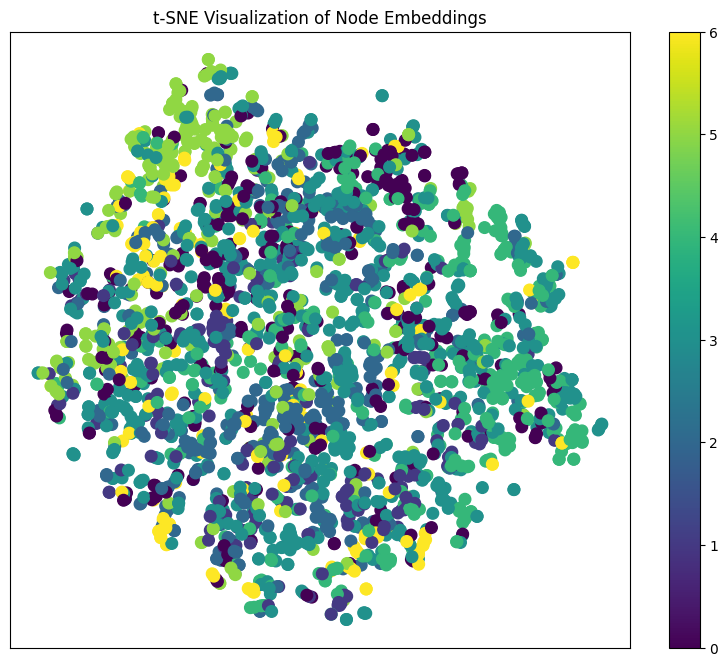

In [59]:
model.eval()
output = model(data.to(device))
color = data.y.detach().cpu().numpy()
visualize_embedding(output, color)

## 绘制混淆矩阵

In [60]:
def show_confusion_matrix(model, data):
    output = model(data)
    _, pred = torch.max(output, 1)
    cm = confusion_matrix(data.y.cpu(), pred.cpu())
    print("Confusion Matrix:")
    print(cm)

In [61]:
show_confusion_matrix(model, data)

Confusion Matrix:
[[ 49   9 161   0  40   5  87]
 [ 18   0  78   0  40   0  81]
 [147  10 160   0  59   0  42]
 [144  32 327   0 155  10 150]
 [ 27   8 120   0 160  23  88]
 [ 22  10 113   0  10   0 143]
 [ 82   2  51   0  14   2  29]]


# 模型训练

## 训练过程

In [62]:
# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [63]:
num_epochs = 200

In [64]:
def train(model, train_loader, criterion, optimizer, device, num_epochs):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        for batch_data in train_loader:
            batch_data = batch_data.to(device)
            optimizer.zero_grad()
            output = model(batch_data)
            train_loss = criterion(output, batch_data.y)
            train_loss.backward()
            optimizer.step()
            train_losses.append(train_loss.item())
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {train_loss.item()}')
    return train_losses

In [65]:
train_losses = train(model, loader, criterion, optimizer, device, num_epochs)

Epoch 10, Train Loss: 1.4490805864334106
Epoch 20, Train Loss: 1.3846417665481567
Epoch 30, Train Loss: 1.3927414417266846
Epoch 40, Train Loss: 1.3834164142608643
Epoch 50, Train Loss: 1.3805770874023438
Epoch 60, Train Loss: 1.3734750747680664
Epoch 70, Train Loss: 1.3676326274871826
Epoch 80, Train Loss: 1.3692971467971802
Epoch 90, Train Loss: 1.3698501586914062
Epoch 100, Train Loss: 1.3660024404525757
Epoch 110, Train Loss: 1.355334997177124
Epoch 120, Train Loss: 1.364620327949524
Epoch 130, Train Loss: 1.3630173206329346
Epoch 140, Train Loss: 1.3504552841186523
Epoch 150, Train Loss: 1.3484313488006592
Epoch 160, Train Loss: 1.3538328409194946
Epoch 170, Train Loss: 1.3579521179199219
Epoch 180, Train Loss: 1.3558955192565918
Epoch 190, Train Loss: 1.3526675701141357
Epoch 200, Train Loss: 1.3562566041946411


## 绘制训练曲线

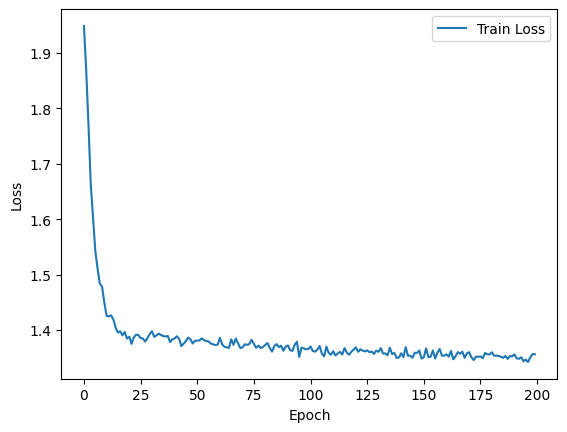

In [66]:
utils.show_train_loss(train_losses)

# 模型测试

In [67]:
def test(model, test_loader, device):
    model.eval()
    correct = 0
    for batch_data in test_loader:
        batch_data = batch_data.to(device)
        output = model(batch_data)
        pred = output.argmax(dim=1)
        correct += pred.eq(batch_data.y).sum().item()
    total = test_loader.dataset[0].num_nodes
    accuracy = correct / total
    return accuracy

In [68]:
accuracy = test(model, loader, device)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9471935007385525


# 可视化分析（训练后）

## 嵌入可视化

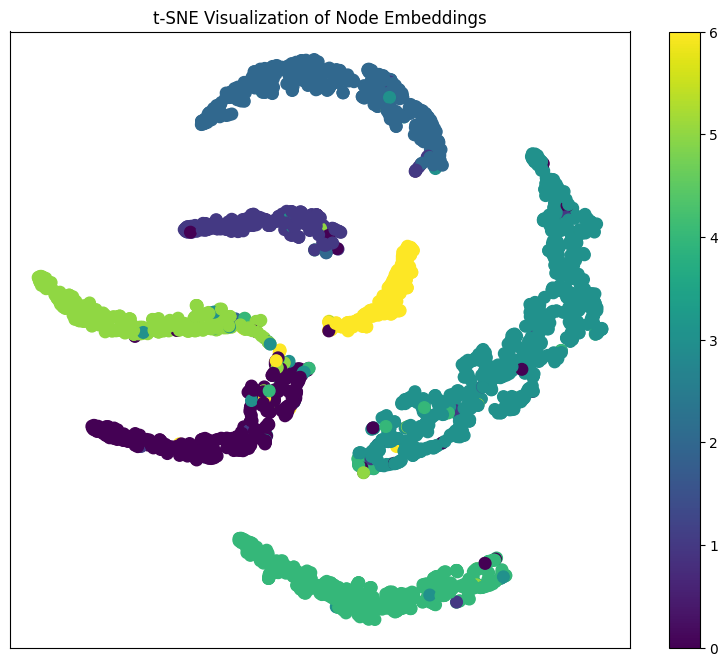

In [69]:
model.eval()
output = model(data)
color = data.y.detach().cpu().numpy()
visualize_embedding(output, color)

## 绘制混淆矩阵

In [70]:
show_confusion_matrix(model, data)

Confusion Matrix:
[[327   5   1  10   3   4   1]
 [  2 201   7   5   1   1   0]
 [  0   1 412   2   0   3   0]
 [ 12   4   6 786   4   6   0]
 [  9   3   0  16 397   1   0]
 [  8   2   3   5   2 277   1]
 [ 11   0   0   1   0   3 165]]
